In [1]:
import pandas as pd
import ptitprince as pt
import numpy as np
import scipy.io
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy.matlib
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

In [2]:
selected_subjects = range(8,27)
excluded_subjects = [13, 14]
selected_subjects = list(set(selected_subjects).symmetric_difference(excluded_subjects))
number_of_subjects = len(selected_subjects)

In [3]:
root_directory = '../data'
hemispheres = ['lh', 'rh']
regressors_of_interest = [
    'Stimulus_{Right,On}',
    'Stimulus_{Left,On}',
    'Stimulus_{Right,Off}',
    'Stimulus_{Left,Off}'
];
layers = ['Deep', 'Middle', 'Top']
regions = ['V1', 'V2', 'V3']

color_palletes = {}
color_palletes['V1'] = ["#ff0000", "#0000ff", "#ff0000", "#0000ff"]
color_palletes['V2'] = ["#ff4000", "#0066ff", "#ff4000", "#0066ff"]
color_palletes['V3'] = ["#ff8000", "#0094ff", "#ff8000", "#0094ff"]

In [4]:
# By no means is this a strict deconvolution, but this is the mechanism by means of 
# which Markuerkiaga et al. (2016) suggest to better estimate layer specific signal
# by filtering out leaked signals from lower layers

layer_separation_matrix = np.matrix([
    [1, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0],
    [0, -0.2, 1, 0, 0],
    [0, -0.04, -0.02, 1, 0],
    [0, 0, 0, 0, 1],
])

def deconvolve_layer_signal(timecourse):
    return layer_separation_matrix * timecourse

In [5]:
def make_figure(method, N, region, plot=True, nLayers=3, deconvolve=False):
    if nLayers == 3:
        layers = ['Deep', 'Middle', 'Top']
    else:
        layers = ['Deep', 'Middle - 1', 'Middle - 2', 'Top']

    results = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
    number_of_layers = nLayers + 2;

    betas = {}
    betas['rh'] = np.zeros((number_of_subjects, number_of_layers, len(regressors_of_interest)))
    betas['lh'] = np.zeros((number_of_subjects, number_of_layers, len(regressors_of_interest)))
    for subject in range(len(selected_subjects)):
        for hemisphere in hemispheres:
            design_matrix = np.empty((0,0))
            regressors = []
            time_course = []
            for chunk in range(1,4):
                subject_directory = '{:s}/SubjectData/Subject{:02d}/Set{:d}'.format(
                    root_directory, selected_subjects[subject], chunk
                )
                design_file = '{:s}/DesignMatrix/DesignStimulus.mat'.format(subject_directory);
                if not os.path.isfile(design_file):
                    continue

                mat = scipy.io.loadmat(design_file)
                d = mat['design']['DesignMatrix'][0,0]
                r = mat['design']['RegressorLabel'][0,0]
                design_matrix = np.concatenate((
                    np.concatenate((design_matrix, np.zeros((d.shape[0], design_matrix.shape[1]))), axis=0),
                    np.concatenate((np.zeros((design_matrix.shape[0], d.shape[1])), d), axis=0)),
                axis=1)
                regressors += [i[0][0] for i in np.transpose(r)]
                design_matrix = pd.DataFrame(data=design_matrix, columns=regressors)

                timecourse_file ='{:s}/TimeCourses/{:s}.{:s}_{:d}v_{:s}.mat'.format(
                    subject_directory, hemisphere, region, N, method
                )
                mat = scipy.io.loadmat(timecourse_file)
                if deconvolve:
                    time_course += [deconvolve_layer_signal(i[0]) for i in mat['timeCourses']]
                else:
                    time_course += [i[0] for i in mat['timeCourses']]

            time_course = np.concatenate((time_course), axis=1)
            model = LinearRegression(fit_intercept=False)
            model.fit(design_matrix, np.transpose(time_course))
            b = pd.DataFrame(model.coef_, columns=regressors)

            for regressor in range(len(regressors_of_interest)):
                percent_signal_change = np.divide(b[regressors_of_interest[regressor]], np.asarray(b['Constant']))
                mean_over_runs = np.mean(percent_signal_change, 1)
                betas[hemisphere][subject,:,regressor] = mean_over_runs
                
                
                if regressor == 0: # 'Stimulus_{Right,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 1: # 'Stimulus_{Left,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                elif regressor == 2: #'Stimulus_{Right,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 3: #'Stimulus_{Left,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                
                for l in range(nLayers):  
                    results = results.append({'Activation': mean_over_runs[l + 1], 'Subject': subject, 'Stimulus': stimulus, 'Attention': attention, 'Layer': layers[l], 'Hemisphere': hemisphere, 'Area': region}, ignore_index=True)
  
    ax = []
    if plot:
        yv, xv = np.meshgrid(layers, regressors_of_interest)
        layer_labels    = np.matrix.flatten(np.transpose(numpy.matlib.repmat(np.matrix.flatten(yv), number_of_subjects, 1)))
        stimulus_labels = np.matrix.flatten(np.transpose(numpy.matlib.repmat(np.matrix.flatten(xv), number_of_subjects, 1)))

        data = (betas['rh'][:,1:(nLayers+1),(1,0,3,2)] + betas['lh'][:,1:(nLayers+1),(0,1,2,3)]) / 2
        data = pd.DataFrame(np.matrix.flatten(np.transpose(data, (2,1,0))), columns=['Activation'])
        data['Task'] = stimulus_labels
        data['Layer'] = layer_labels

        dx   = "Layer"; 
        dy   = "Activation"; 
        dhue = "Task"
        pal  = sns.color_palette(color_palletes[region])

        plt.figure()
        ax = pt.RainCloud(
            data       = data, 
            x          = dx, 
            y          = dy,
            hue        = dhue, 
            palette    = pal, 
            bw         = .4, 
            width_viol = .5,
            orient     = 'v' , 
            alpha      = .6, 
            dodge      = True, 
            pointplot  = True, 
            move       = 0.1    
        )
        ax.set_ylim(-0.03, 0.1)
        ax.set_yticks([x * 0.02 for x in range(-1, 6, 1)])
        ax.set_yticklabels(['{:,.1%}'.format(x * 0.02) for x in range(-1, 6, 1)])

        plt.title("Layer Activation in {:s}, ROI of {:d} vertices, signal extracted with {:s}".format(region, N, method))
        if deconvolve:
            plt.savefig(f'./img/{N}Vertices/{region}_{method}_deconvolved.png', bbox_inches='tight')
            plt.savefig(f'./img/{N}Vertices/{region}_{method}_deconvolved.pdf', bbox_inches='tight')

    return [results, ax]

Some plot styling functions:

In [6]:
def color_significant_values(value):
    if value > 0.05:
        color = "black"
    elif value > 0.01:
        color = 'darkred'
    else:
        color = 'green'
    return 'color: %s' % color

def bold_face(value):
    return 'font-weight: bold'

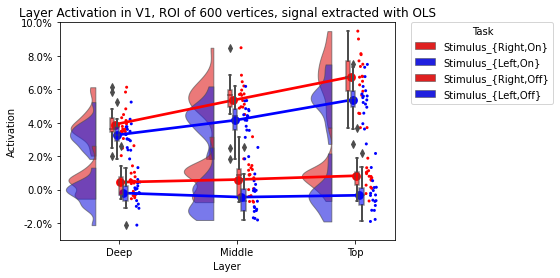

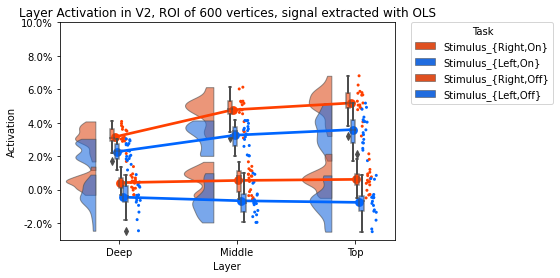

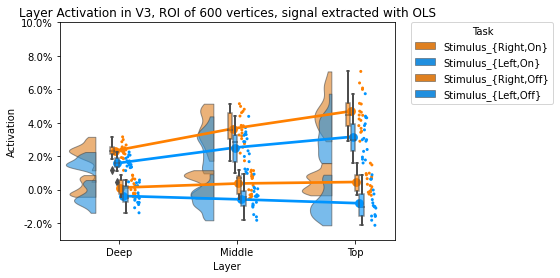

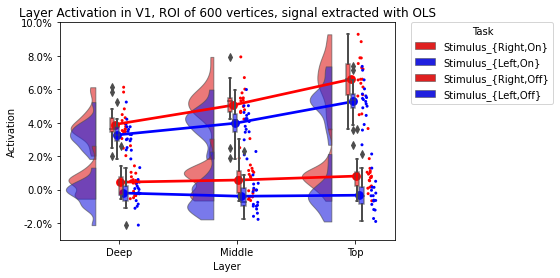

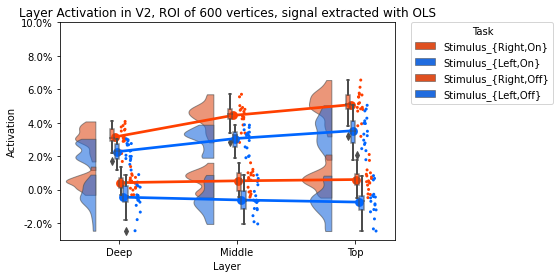

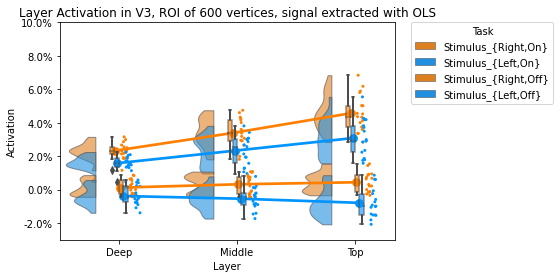

In [7]:
regions = ['V1', 'V2', 'V3']
methods = ['OLS']
vertices = [600]
plot= True

group_results = pd.DataFrame()
for deconvolve in [True, False]:
    for method in methods:
        for N in vertices:
            betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
            for region in regions:
                [a, _] = make_figure(method, N, region, plot=plot, deconvolve=deconvolve)
                betas = betas.append(a)

            aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
            res = aov_table.fit()
            if deconvolve:
                group_results[f"{method},{N},Deconvolved"] = res.summary().tables[0]['Pr > F']
            else:
                group_results[f"{method},{N}"] = res.summary().tables[0]['Pr > F']

res = aov_table.fit()

hemipshere_string = 'Hemisphere'
rows = res.summary().tables[0].index.values
selected_rows = [str for str in rows if hemipshere_string not in str];
selected_rows.insert(4, hemipshere_string)

In black, p-value above 0.05
In red, p-values below 0.05
In green, p-values below 0.01


In [8]:
selected_columns = ['OLS,600','OLS,600,Deconvolved']
rows = group_results.index.values
group_results.loc[selected_rows,selected_columns] \
    .style \
    .applymap(color_significant_values) \
    .format({'OLS,600': "{:.4e}", 'OLS,600,Deconvolved': "{:.4e}" })

,"OLS,600","OLS,600,Deconvolved"
Stimulus,1.6484e-12,2.0947e-12
Attention,1.0325e-08,9.5412e-09
Layer,1.0675e-13,9.3217e-13
Area,1.1341e-08,1.7993e-08
Hemisphere,9.9150e-01,9.7992e-01
Stimulus:Attention,7.3318e-02,6.7388e-02
Stimulus:Layer,1.4331e-13,8.0837e-13
Attention:Layer,8.3352e-10,2.0231e-09
Stimulus:Area,9.4247e-10,1.7312e-09
Attention:Area,7.2539e-02,8.4479e-02
